<a href="https://colab.research.google.com/github/BankNatchapol/Comparison-of-Quantum-Gradient/blob/main/discrete_vs_continuous/sampling_continuous_gradient_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pennylane-sf
!pip install qiskit
!pip install qiskit_optimization

     |████████████████████████████████| 4.9 MB 6.5 MB/s 
     |████████████████████████████████| 881 kB 18.0 MB/s 
     |████████████████████████████████| 8.2 MB 26.2 MB/s 
     |████████████████████████████████| 1.6 MB 38.9 MB/s 
     |████████████████████████████████| 108 kB 41.5 MB/s 
     |████████████████████████████████| 138 kB 50.2 MB/s 
     |████████████████████████████████| 47 kB 4.6 MB/s 
     |████████████████████████████████| 83 kB 2.2 MB/s 
     |████████████████████████████████| 112 kB 37.6 MB/s 
     |████████████████████████████████| 103 kB 32.3 MB/s 
     |████████████████████████████████| 127 kB 8.7 MB/s 
     |████████████████████████████████| 87 kB 5.2 MB/s 
     |████████████████████████████████| 10.9 MB 22.4 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=a4bdfd2e7b712740715eae71400024c7cd2e2e0f8fd8352f29f31d55cee0a383
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4c

In [3]:
import pennylane as qml
from pennylane import numpy as np

from pandas.plotting import table 
import pandas as pd
import time 

import networkx as nx
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objects as go
import plotly.express as px

from docplex.mp.model import Model
from qiskit.opflow import Z, X, Y, I
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications import Maxcut, Clique, Knapsack
from qiskit_optimization.converters import QuadraticProgramToQubo

In [4]:
#@title Auxilary Function
def Had(wires):
  qml.RY(np.pi/2, wires=wires)
  qml.RX(np.pi, wires=wires)


def fully_connected_layer(num_wires):
  if num_wires>1:
    for wire in range(num_wires-1):
      qml.CNOT(wires=[wire, wire+1])
    qml.CNOT(wires=[wire+1, 0])

def fully_connected_layer_cv(num_wires, var):
  if num_wires>1:
    for wire in range(num_wires-1):
      qml.Beamsplitter(var[wire], np.pi/2, wires=[wire, wire+1])
    qml.Beamsplitter(var[-1], np.pi/2, wires=[wire+1, 0])

def str2gate(gate):
  if gate == 'H':
    return Had
  elif gate == 'X':
    return qml.PauliX
  elif gate == 'Y':
    return qml.PauliY
  elif gate == 'Z':
    return qml.PauliZ
  elif gate == 'RX':
    return qml.RX
  elif gate == 'RY':
    return qml.RY
  elif gate == 'RZ':
    return qml.RZ
  else:
    assert 0, "Gate not support."

def controlStr(gate):
  if gate == 'RX':
    return qml.CNOT
  elif gate == 'RY':
    return qml.CY
  elif gate == 'RZ':
    return qml.CZ
  else:
    assert 0, "Gate not support."
    
def hamiltonian_from_qiskit(sum_op):

	'''
	This function takes a qiskit.PauliSumOp as input and
	gives back a Pennylane Hamiltonian as output

	sum_op  = qiskit.PauliSumOp

	'''
	op      = sum_op.primitive.to_list()
	n_terms = len(op)
	coeffs  = []
	paulis  = []

	for i in range(n_terms):
		paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))))
		coeffs.append(op[i][1].real)

	p_op = qml.Hamiltonian(coeffs,paulis)

	return p_op

def hamiltonian_from_qiskit_lcu(sum_op):

  '''
  This function takes a qiskit.PauliSumOp as input and
  gives back a Pennylane Hamiltonian as output

  sum_op  = qiskit.PauliSumOp

  '''
  op      = sum_op.primitive.to_list()
  n_terms = len(op)
  coeffs  = []
  paulis  = []

  for i in range(n_terms):
    if op[i][0]=="I":
      paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))))
    else:
      paulis.append(qml.grouping.string_to_pauli_word("".join(list(reversed(op[i][0])))+"Z"))
    coeffs.append(op[i][1].real)

  p_op = qml.Hamiltonian(coeffs,paulis)

  return p_op

def get_adjacency_matrix(elist):
  adjacency_matrix = np.zeros([num_wires, num_wires])

  for i,j in elist:
    adjacency_matrix[i, j] = 1.0
    adjacency_matrix[j, i] = 1.0

  return adjacency_matrix

def draw_graph(elist, colors):
  G = nx.Graph()
  #G.add_nodes_from(np.arange(0, n, 1))
  # tuple is (i,j,weight) where (i,j) is the edge
  G.add_edges_from(elist)
  pos = nx.spring_layout(G)
  default_axes = plt.axes(frameon=True)
  nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)

def int_to_binary(value, size):
  """Function that converts an integer to a binary string."""

  bi = "{0:b}".format(value)
  if len(bi)<size:
    bi = "0"*(size-len(bi)) + bi
  return bi

# **Gradient methods**

## Continuous-variable

### Parameter shift rule

In [5]:
def parameter_shift_cv_term(qnode, params, i, j, gate):
    s = 0.1
    alpha = np.pi/2
    

    shifted = params.copy()

    if gate == 'R' or gate == 'S2' or gate == 'D2' or gate == 'BS1':
      shifted[i, j] += alpha
      forward = qnode(shifted)  # forward evaluation

      shifted[i, j] -= 2*alpha
      backward = qnode(shifted) # backward evaluation

      return (1/2) * (forward - backward)

    elif gate == 'S1':
      shifted[i, j] += s
      forward = qnode(shifted)  # forward evaluation

      shifted[i, j] -= 2*s
      backward = qnode(shifted) # backward evaluation

      return (1/(2*np.sinh(s))) * (forward - backward)
    
    elif gate == 'D1' or gate == 'QP':
      shifted[i, j] += s
      forward = qnode(shifted)  # forward evaluation

      shifted[i, j] -= 2*s
      backward = qnode(shifted) # backward evaluation

      return (1/(2*s)) * (forward - backward)

def parameter_shift_cv(qnode, params, ansatz_label_cv):

    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gate = ansatz_label_cv[i*len(gradients[0]) + j]
            gradients[i, j] += parameter_shift_cv_term(qnode, params, i, j, gate)

    return gradients

### Finite difference

In [6]:
def finite_cv_term(qnode, params, i, j):
    
    eps = 0.01

    shifted = params.copy()
    
    shifted[i, j] += eps
    forward = qnode(shifted)  # forward evaluation

    shifted[i, j] -= 2*eps
    backward = qnode(shifted) # backward evaluation

    return (1/(2*eps)) * (forward - backward)

def finite_difference_cv(qnode, params):
    gradients = np.zeros_like((params))
    for i in range(len(gradients)):
        for j in range(len(gradients[0])):
            gradients[i, j] += finite_cv_term(qnode, params, i, j)

    return gradients

# **Problem Fomulation** 

## Max-Cut

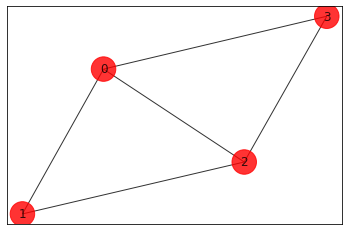

In [7]:
num_wires = 4  # Number of nodes in graph

elist_maxcut = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
colors_maxcut = ["r" for node in range(num_wires)]

draw_graph(elist_maxcut, colors_maxcut)

In [8]:
adjacency_matrix_maxcut = get_adjacency_matrix(elist_maxcut)
max_cut = Maxcut(adjacency_matrix_maxcut)
qp_maxcut = max_cut.to_quadratic_program()
print(qp_maxcut.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: 3 x_0 + 2 x_1 + 3 x_2 + 2 x_3 + [ - 4 x_0*x_1 - 4 x_0*x_2 - 4 x_0*x_3
      - 4 x_1*x_2 - 4 x_2*x_3 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



In [9]:
qubitOp_maxcut, offset_maxcut = qp_maxcut.to_ising()
H_maxcut = hamiltonian_from_qiskit(qubitOp_maxcut)
H_maxcut_lcu = hamiltonian_from_qiskit_lcu(qubitOp_maxcut)
print("Offset:", offset_maxcut,"\n")
print("Ising Hamiltonian:\n")

print(H_maxcut)

Offset: -2.5 

Ising Hamiltonian:

  (0.5) [Z2 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z0 Z3]
+ (0.5) [Z0 Z2]
+ (0.5) [Z0 Z1]


## Clique

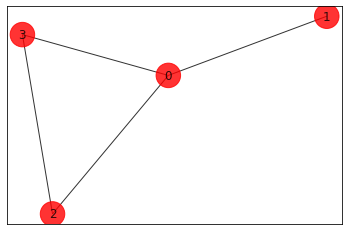

In [10]:
num_wires = 4  # Number of nodes in graph

elist_clique = [(0, 1), (0, 2), (0, 3), (2, 3)]
colors_clique = ["r" for node in range(num_wires)]

draw_graph(elist_clique, colors_clique)

In [11]:
adjacency_matrix_clique = get_adjacency_matrix(elist_clique)
clique = Clique(adjacency_matrix_clique)
qp_clique = clique.to_quadratic_program()
print(qp_clique.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Clique

Maximize
 obj: x_0 + x_1 + x_2 + x_3
Subject To
 c0: x_1 + x_2 <= 1
 c1: x_1 + x_3 <= 1

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End



In [12]:
qp2qubo = QuadraticProgramToQubo()
qubo_clique = qp2qubo.convert(qp_clique)

qubitOp_clique, offset_clique = qubo_clique.to_ising()
H_clique = hamiltonian_from_qiskit(qubitOp_clique)
H_clique_lcu = hamiltonian_from_qiskit_lcu(qubitOp_clique)

print("Offset:", offset_clique,"\n")
print("Ising Hamiltonian:\n")

print(H_clique)

Offset: 0.5 

Ising Hamiltonian:

  (-2.0) [Z1]
+ (-0.75) [Z3]
+ (-0.75) [Z2]
+ (0.5) [Z0]
+ (1.25) [Z1 Z3]
+ (1.25) [Z1 Z2]


## Binary Linear Programming

In [13]:
blp = Model("docplex model")
x1 = blp.binary_var("x1")
x2 = blp.binary_var("x2")
x3 = blp.binary_var("x3")
x4 = blp.binary_var("x4")

blp.minimize(195000*x1 + 96000*x2 + 87000*x3 + 120000*x4)
blp.add_constraint(x1  + x3 >= 1)
blp.add_constraint(x2 + x4 >= 1)

# load from a Docplex model
qp_blp = from_docplex_mp(blp)
print(qp_blp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: 195000 x1 + 96000 x2 + 87000 x3 + 120000 x4
Subject To
 c0: x1 + x3 >= 1
 c1: x2 + x4 >= 1

Bounds
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x1 x2 x3 x4
End



In [14]:
qubo_blp = qp2qubo.convert(qp_blp)

qubitOp_blp, offset_blp = qubo_blp.to_ising()
H_blp = hamiltonian_from_qiskit(qubitOp_blp)
H_blp_lcu = hamiltonian_from_qiskit_lcu(qubitOp_blp)

print("Offset:", offset_blp,"\n")
print("Ising Hamiltonian:\n")

print(H_blp)

Offset: 498000.5 

Ising Hamiltonian:

  (27000.25) [Z0]
+ (64500.25) [Z3]
+ (76500.25) [Z1]
+ (81000.25) [Z2]
+ (124500.25) [Z1 Z3]
+ (124500.25) [Z0 Z2]


## Knapsack

In [15]:
weights = [1, 2]
profits = [2, 1]
max_weight = 3
knapsack = Knapsack(profits, weights, max_weight)
qp_ks = knapsack.to_quadratic_program()
print(qp_ks.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Maximize
 obj: 2 x_0 + x_1
Subject To
 c0: x_0 + 2 x_1 <= 3

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1

Binaries
 x_0 x_1
End



In [16]:
qubo_ks = qp2qubo.convert(qp_ks)

qubitOp_ks, offset_ks = qubo_ks.to_ising()
H_ks = hamiltonian_from_qiskit(qubitOp_ks)
H_ks_lcu = hamiltonian_from_qiskit_lcu(qubitOp_ks)

print("Offset:", offset_ks,"\n")
print("Ising Hamiltonian:\n")

print(H_ks)

Offset: 8.5 

Ising Hamiltonian:

  (0.5) [Z1]
+ (1.0) [Z0]
+ (2.0) [Z0 Z2]
+ (4.0) [Z2 Z3]
+ (4.0) [Z1 Z2]
+ (4.0) [Z0 Z3]
+ (4.0) [Z0 Z1]
+ (8.0) [Z1 Z3]


# **Optimization**

## Discrete-variable

In [17]:
# guesting ansatz state

def ansatz_label_cv(num_wires, num_layers):
  label = []
  for l in range(num_layers):
    for wire in range(num_wires):
      label.append("R")
      label.append("D1")
    for wire in range(num_wires):
      label.append("BS1")
  return label

def ansatz_cv(var, num_wires_cv):
    for wire in range(num_wires_cv):
      qml.Rotation(var[0+2*wire], wires=wire)
      qml.Displacement(var[1+2*wire], 0.0, wires=wire)
    fully_connected_layer_cv(num_wires, var[2+2*(num_wires_cv-1):])

In [32]:
def cost_function_cv(var, problem, num_wires, cutoff_dim):
  
  dev = qml.device("strawberryfields.fock", wires=num_wires, cutoff_dim=cutoff_dim, shots=1024)
  @qml.qnode(dev)
  def circuit(var):
    for v in var: 
      ansatz_cv(v, num_wires)
    return [qml.expval(qml.X(i)) for i in range(num_wires)]
  
  answer = circuit(var)
  bi_answer = [a.numpy()/(cutoff_dim-1) for a in answer]
  return problem.objective.evaluate(bi_answer)

Probability distribution of estimated gate 

In [33]:
# prediction circuit
def prediction_cv(var, num_param_gates, cutoff_dim):
  num_wires = len(var[0])//num_param_gates
  dev = qml.device("strawberryfields.fock", wires=num_wires, cutoff_dim=cutoff_dim, shots=1024)
  @qml.qnode(dev)
  def circuit(var):
    for v in var: 
      ansatz_cv(v, num_wires)
    return [qml.expval(qml.X(i)) for i in range(num_wires)] 
  
  answer = circuit(var)
  bi_answer = [a.numpy()/(cutoff_dim-1) for a in answer]
  return bi_answer

In [34]:
np.random.seed(2)
num_layers = 2
num_param_gates = 3
cutoff_dim = 5

var_init_maxcut = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))
var_init_clique = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))
var_init_blp = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))
var_init_ks = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

steps = [2, 4, 6, 8, 10]

In [35]:
print("Initial cost: ", -cost_function_cv(var_init_maxcut, qp_maxcut, len(H_maxcut.wires), cutoff_dim))

Initial cost:  0.5336725944833377


In [36]:
print("Prediction: ", prediction_cv(var_init_maxcut, num_param_gates, cutoff_dim))

Prediction:  [-0.3087306983435831, 0.12527567101861573, 0.06103951487970346, -0.04865571758676593]


Function for training optimizer

In [37]:
def train(cost_fn, grad_fn, epochs, var_init, lr):
  lost_list = []
  time_list = []

  var = var_init.copy()

  opt = qml.RMSPropOptimizer(lr)

  start = time.time()

  for it in range(epochs):# while True:
      var, _cost = opt.step_and_cost(cost_fn, var, grad_fn=grad_fn) 
      lost_list.append(_cost)

      if it%10==0:
        print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

      end = time.time()
      t = end - start
      time_list.append(t)

  return lost_list, time_list, var

Varaible List

In [38]:
# lost list
cvpsl = []
cvfdl = []

# time list
cvpst = []
cvfdt = []


# lost list change num layer
cvpslc = []
cvfdlc = []

# time list change num layer
cvpstc = []
cvfdtc = []

### Parameter Shift Rule

#### Max-Cut

In [39]:
lr = 0.03
epochs = 101

label = ansatz_label_cv(len(H_maxcut.wires), len(var_init_maxcut))

cost_fn = lambda v: -cost_function_cv(v, qp_maxcut, len(H_maxcut.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: -cost_function_cv(x, qp_maxcut, len(H_maxcut.wires), cutoff_dim), var, label)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)

cvpsl.append(lost_list)
cvpst.append(time_list)

Iter:     0 | Cost: 0.57175791624 
Iter:    10 | Cost: -2.38771222697 
Iter:    20 | Cost: -2.46891958391 
Iter:    30 | Cost: -2.53159607383 
Iter:    40 | Cost: -2.68634681885 
Iter:    50 | Cost: -2.68157223381 
Iter:    60 | Cost: -2.79024165274 
Iter:    70 | Cost: -2.82770393669 
Iter:    80 | Cost: -2.79284391770 
Iter:    90 | Cost: -2.84310259006 
Iter:   100 | Cost: -2.78890838610 


In [40]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))
  label = ansatz_label_cv(len(H_maxcut.wires), len(var_init_maxcutc))
  cost_fn = lambda v: -cost_function_cv(v, qp_maxcut, len(H_maxcut.wires), cutoff_dim)
  grad_fn = lambda var: parameter_shift_cv(lambda x: -cost_function_cv(x, qp_maxcut, len(H_maxcut.wires), cutoff_dim), var, label)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvpslc.append(temp1)
cvpstc.append(temp2)

Iter:     0 | Cost: 2.11501795830 
Iter:    10 | Cost: -2.23440884042 
Iter:     0 | Cost: 0.21943878671 
Iter:    10 | Cost: -2.75480239680 
Iter:     0 | Cost: -0.04711320585 
Iter:    10 | Cost: -2.59306139448 
Iter:     0 | Cost: 0.81542054704 
Iter:    10 | Cost: -2.29437817119 
Iter:     0 | Cost: 0.00864426373 
Iter:    10 | Cost: -2.47764760268 


#### Clique

In [41]:
lr = 0.03
epochs = 101

label = ansatz_label_cv(len(H_clique.wires), len(var_init_clique))

cost_fn = lambda v: -cost_function_cv(v, qp_clique, len(H_clique.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: -cost_function_cv(x, qp_clique, len(H_clique.wires), cutoff_dim), var, label)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
cvpsl.append(lost_list)
cvpst.append(time_list)

Iter:     0 | Cost: -0.16173695152 
Iter:    10 | Cost: -1.48637155278 
Iter:    20 | Cost: -1.91893419579 
Iter:    30 | Cost: -2.08451069713 
Iter:    40 | Cost: -2.13023465812 
Iter:    50 | Cost: -2.10071486794 
Iter:    60 | Cost: -2.13928740299 
Iter:    70 | Cost: -2.13372987955 
Iter:    80 | Cost: -2.12196505956 
Iter:    90 | Cost: -2.14205757907 
Iter:   100 | Cost: -2.16121065009 


In [42]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))
  label = ansatz_label_cv(len(H_clique.wires), len(var_init_cliquec))
  cost_fn = lambda v: -cost_function_cv(v, qp_clique, len(H_clique.wires), cutoff_dim)
  grad_fn = lambda var: parameter_shift_cv(lambda x: -cost_function_cv(x, qp_clique, len(H_clique.wires), cutoff_dim), var, label)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvpslc.append(temp1)
cvpstc.append(temp2)

Iter:     0 | Cost: 0.64855082019 
Iter:    10 | Cost: -1.53032017693 
Iter:     0 | Cost: 0.06418536312 
Iter:    10 | Cost: -1.91489368159 
Iter:     0 | Cost: -0.01966883802 
Iter:    10 | Cost: -1.68818427531 
Iter:     0 | Cost: 0.28915696157 
Iter:    10 | Cost: -1.48293859623 
Iter:     0 | Cost: 0.00308441870 
Iter:    10 | Cost: -1.54460717385 


#### Binary Linear Programming

In [43]:
lr = 0.03
epochs = 101

label = ansatz_label_cv(len(H_blp.wires), len(var_init_blp))

cost_fn = lambda v: cost_function_cv(v, qubo_blp, len(H_blp.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv(x, qubo_blp, len(H_blp.wires), cutoff_dim), var, label)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
cvpsl.append(lost_list)
cvpst.append(time_list)

Iter:     0 | Cost: 952719.44478895480 
Iter:    10 | Cost: 553697.51926415926 
Iter:    20 | Cost: 542707.37189880642 
Iter:    30 | Cost: 523038.02589569404 
Iter:    40 | Cost: 507325.13443897699 
Iter:    50 | Cost: 513981.86910072877 
Iter:    60 | Cost: 516376.72505276703 
Iter:    70 | Cost: 521173.38745622837 
Iter:    80 | Cost: 512033.34998035629 
Iter:    90 | Cost: 518854.86395863350 
Iter:   100 | Cost: 513834.51033856900 


In [44]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))
  label = ansatz_label_cv(len(H_blp.wires), len(var_init_blpc))
  cost_fn = lambda v: cost_function_cv(v, qubo_blp, len(H_blp.wires), cutoff_dim)
  grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv(x, qubo_blp, len(H_blp.wires), cutoff_dim), var, label)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvpslc.append(temp1)
cvpstc.append(temp2)

Iter:     0 | Cost: 1244940.84654680430 
Iter:    10 | Cost: 592369.71319303988 
Iter:     0 | Cost: 997387.20263886999 
Iter:    10 | Cost: 533430.26176343404 
Iter:     0 | Cost: 988452.51198139484 
Iter:    10 | Cost: 539056.04982331523 
Iter:     0 | Cost: 1108039.62132556783 
Iter:    10 | Cost: 568412.27770484006 
Iter:     0 | Cost: 996483.17970308266 
Iter:    10 | Cost: 549024.68481044099 


#### Knapsack

In [45]:
lr = 0.03
epochs = 101

label = ansatz_label_cv(len(H_ks.wires), len(var_init_ks))

cost_fn = lambda v: cost_function_cv(v, qubo_ks, len(H_ks.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv(x, qubo_ks, len(H_ks.wires), cutoff_dim), var, label)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
cvpsl.append(lost_list)
cvpst.append(time_list)

Iter:     0 | Cost: 20.58105307650 
Iter:    10 | Cost: 0.75044773733 
Iter:    20 | Cost: -0.87356596569 
Iter:    30 | Cost: -1.33620355478 
Iter:    40 | Cost: -1.48785207181 
Iter:    50 | Cost: -1.60310566504 
Iter:    60 | Cost: -1.64372190418 
Iter:    70 | Cost: -1.63020669125 
Iter:    80 | Cost: -1.60034233311 
Iter:    90 | Cost: -1.57603830697 
Iter:   100 | Cost: -1.56221332529 


In [46]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))
  label = ansatz_label_cv(len(H_ks.wires), len(var_init_ksc))
  cost_fn = lambda v: cost_function_cv(v, qubo_ks, len(H_ks.wires), cutoff_dim)
  grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv(x, qubo_ks, len(H_ks.wires), cutoff_dim), var, label)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvpslc.append(temp1)
cvpstc.append(temp2)

Iter:     0 | Cost: 55.93479557923 
Iter:    10 | Cost: 2.78305294850 
Iter:     0 | Cost: 36.19174871435 
Iter:    10 | Cost: -1.16944144893 
Iter:     0 | Cost: 35.24099111664 
Iter:    10 | Cost: -0.05980229311 
Iter:     0 | Cost: 45.98696301030 
Iter:    10 | Cost: 0.58339571196 
Iter:     0 | Cost: 36.10249507488 
Iter:    10 | Cost: -0.45220527232 


### Finite Difference

#### Max-Cut

In [47]:
lr = 0.03
epochs = 101

cost_fn = lambda v: -cost_function_cv(v, qp_maxcut, len(H_maxcut.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: -cost_function_cv(x, qp_maxcut, len(H_maxcut.wires), cutoff_dim), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_maxcut, lr)
cvfdl.append(lost_list)
cvfdt.append(time_list)

Iter:     0 | Cost: 0.57232528734 
Iter:    10 | Cost: -1.45295433144 
Iter:    20 | Cost: -1.87692788467 
Iter:    30 | Cost: -2.31601122386 
Iter:    40 | Cost: -2.36254121232 
Iter:    50 | Cost: -2.31149030721 
Iter:    60 | Cost: -2.43515885507 
Iter:    70 | Cost: -2.42570952965 
Iter:    80 | Cost: -2.26461498296 
Iter:    90 | Cost: -2.42747376327 
Iter:   100 | Cost: -2.59252794403 


In [48]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_maxcutc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_maxcut.wires))

  cost_fn = lambda v: -cost_function_cv(v, qp_maxcut, len(H_maxcut.wires), cutoff_dim)
  grad_fn = lambda var: finite_difference_cv(lambda x: -cost_function_cv(x, qp_maxcut, len(H_maxcut.wires), cutoff_dim), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_maxcutc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvfdlc.append(temp1)
cvfdtc.append(temp2)

Iter:     0 | Cost: 2.11501795830 
Iter:    10 | Cost: -0.62443234581 
Iter:     0 | Cost: 0.21943878671 
Iter:    10 | Cost: -2.18542465488 
Iter:     0 | Cost: -0.04711320585 
Iter:    10 | Cost: -0.02840093570 
Iter:     0 | Cost: 0.81542054704 
Iter:    10 | Cost: -1.33776054230 
Iter:     0 | Cost: 0.00864426373 
Iter:    10 | Cost: 0.01693598569 


#### Clique

In [49]:
lr = 0.03
epochs = 101

cost_fn = lambda v: -cost_function_cv(v, qp_clique, len(H_clique.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: -cost_function_cv(x, qp_clique, len(H_clique.wires), cutoff_dim), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_clique, lr)
cvfdl.append(lost_list)
cvfdt.append(time_list)

Iter:     0 | Cost: -0.16173695152 
Iter:    10 | Cost: -0.68853934622 
Iter:    20 | Cost: -0.89638069638 
Iter:    30 | Cost: -1.26077030494 
Iter:    40 | Cost: -1.51594348453 
Iter:    50 | Cost: -1.52714363037 
Iter:    60 | Cost: -1.61602317141 
Iter:    70 | Cost: -1.73182681382 
Iter:    80 | Cost: -1.75842780526 
Iter:    90 | Cost: -1.86295220689 
Iter:   100 | Cost: -1.88798568138 


In [50]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_cliquec = 0.5*np.random.randn(num_layers, num_param_gates*len(H_clique.wires))

  cost_fn = lambda v: -cost_function_cv(v, qp_clique, len(H_clique.wires), cutoff_dim)
  grad_fn = lambda var: finite_difference_cv(lambda x: -cost_function_cv(x, qp_clique, len(H_clique.wires), cutoff_dim), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_cliquec, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvfdlc.append(temp1)
cvfdtc.append(temp2)

Iter:     0 | Cost: 0.64855082019 
Iter:    10 | Cost: -0.36279923501 
Iter:     0 | Cost: 0.06418536312 
Iter:    10 | Cost: -1.48611055347 
Iter:     0 | Cost: -0.01966883802 
Iter:    10 | Cost: -0.01993938210 
Iter:     0 | Cost: 0.28915696157 
Iter:    10 | Cost: -0.75216651072 
Iter:     0 | Cost: 0.00308441870 
Iter:    10 | Cost: -0.00207087439 


#### Binary Linear Programming

In [51]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function_cv(v, qubo_blp, len(H_blp.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv(x, qubo_blp, len(H_blp.wires), cutoff_dim), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_blp, lr)
cvfdl.append(lost_list)
cvfdt.append(time_list)

Iter:     0 | Cost: 952719.44478895480 
Iter:    10 | Cost: 679652.04327801231 
Iter:    20 | Cost: 634371.70293571358 
Iter:    30 | Cost: 601178.97566875070 
Iter:    40 | Cost: 595300.64827217674 
Iter:    50 | Cost: 603509.33864100208 
Iter:    60 | Cost: 571547.89638588182 
Iter:    70 | Cost: 579896.66734976484 
Iter:    80 | Cost: 568295.52587929042 
Iter:    90 | Cost: 555477.75474944513 
Iter:   100 | Cost: 541555.21025339467 


In [52]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_blpc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_blp.wires))

  cost_fn = lambda v: cost_function_cv(v, qubo_blp, len(H_blp.wires), cutoff_dim)
  grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv(x, qubo_blp, len(H_blp.wires), cutoff_dim), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_blpc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvfdlc.append(temp1)
cvfdtc.append(temp2)

Iter:     0 | Cost: 1244940.84654680430 
Iter:    10 | Cost: 808413.60151885496 
Iter:     0 | Cost: 997387.20263886999 
Iter:    10 | Cost: 613346.16169291059 
Iter:     0 | Cost: 988452.51198139484 
Iter:    10 | Cost: 987463.18004472938 
Iter:     0 | Cost: 1108039.62132556783 
Iter:    10 | Cost: 704743.63105448231 
Iter:     0 | Cost: 996483.17970308266 
Iter:    10 | Cost: 984850.94235015905 


#### Knapsack

In [53]:
lr = 0.03
epochs = 101

cost_fn = lambda v: cost_function_cv(v, qubo_ks, len(H_ks.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv(x, qubo_ks, len(H_ks.wires), cutoff_dim), var)
lost_list, time_list, var = train(cost_fn, grad_fn, epochs, var_init_ks, lr)
cvfdl.append(lost_list)
cvfdt.append(time_list)

Iter:     0 | Cost: 20.58105307650 
Iter:    10 | Cost: 10.92390743128 
Iter:    20 | Cost: 8.54885967423 
Iter:    30 | Cost: 5.06410306139 
Iter:    40 | Cost: 3.92737816476 
Iter:    50 | Cost: 4.06782709535 
Iter:    60 | Cost: 2.41891362090 
Iter:    70 | Cost: 1.16585301920 
Iter:    80 | Cost: 1.13638851310 
Iter:    90 | Cost: 0.48577217654 
Iter:   100 | Cost: 0.34116767785 


In [54]:
lr = 0.03
epochs = 11

np.random.seed(1)
num_param_gates = 3

temp1 = []
temp2 = []

for num_layers in steps:
  var_init_ksc = 0.5*np.random.randn(num_layers, num_param_gates*len(H_ks.wires))

  cost_fn = lambda v: cost_function_cv(v, qubo_ks, len(H_ks.wires), cutoff_dim)
  grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv(x, qubo_ks, len(H_ks.wires), cutoff_dim), var)
  lost_list, time_list, _ = train(cost_fn, grad_fn, epochs, var_init_ksc, lr)
  temp1.append(lost_list[-1])
  temp2.append(time_list[-1])

cvfdlc.append(temp1)
cvfdtc.append(temp2)

Iter:     0 | Cost: 55.93479557923 
Iter:    10 | Cost: 20.98970110092 
Iter:     0 | Cost: 36.19174871435 
Iter:    10 | Cost: 3.23339062299 
Iter:     0 | Cost: 35.24099111664 
Iter:    10 | Cost: 34.81989793190 
Iter:     0 | Cost: 45.98696301030 
Iter:    10 | Cost: 11.73758905803 
Iter:     0 | Cost: 36.10249507488 
Iter:    10 | Cost: 29.71433219983 


#**Benchmarking** 

### Contour Plot

In [55]:
#@title Train Contour
def train_contour(cost_fn, grad_fn, epochs, var_init, lr):
  lost_list = []
  var_list = []
  var = var_init.copy()
  var_list.append(var)
  opt = qml.RMSPropOptimizer(lr)

  start = time.time()

  for it in range(epochs):# while True:
      
      var, _cost = opt.step_and_cost(cost_fn, var, grad_fn=grad_fn) 
      lost_list.append(_cost)
      var_list.append(var)
      # if it%10==0:
      #   print("Iter: {:5d} | Cost: {:0.11f} ".format(it, _cost))

      end = time.time()
      t = end - start
  return lost_list, var_list

In [56]:
#@title Gradient Plot
blp = Model("docplex model")
x1 = blp.binary_var("x1")

blp.minimize(95000*x1)
blp.add_constraint(x1 >= 1)
# load from a Docplex model
qp_blp = from_docplex_mp(blp)
print(qp_blp.export_as_lp_string())
qubo_blp = qp2qubo.convert(qp_blp) 
qubitOp_blp, offset_contour = qubo_blp.to_ising()

qubitOp_blp += 0.5*I
H_contour = hamiltonian_from_qiskit(qubitOp_blp)

from tqdm.notebook import tqdm
# objective function
def ansatz_cv_contour(var):
    qml.Rotation(var[0], wires=0)
    qml.Displacement(var[1], 0.0, wires=0)
  
def cost_function_cv_contour(var, problem, num_wires, cutoff_dim):
  
  dev = qml.device("strawberryfields.fock", wires=num_wires, cutoff_dim=cutoff_dim)
  @qml.qnode(dev)
  def circuit(var):
    ansatz_cv_contour(var[0])
    return [qml.expval(qml.X(i)) for i in range(num_wires)]
  
  answer = circuit(var)
  bi_answer = [a/(cutoff_dim-1) for a in answer]
  return problem.objective.evaluate(bi_answer)


X = np.linspace(-8, 8, 50)
Y = np.linspace(-8, 8, 50)
X_m, Y_m = np.meshgrid(X, Y)
Z = np.zeros((50, 50))
for i in tqdm(range(50)):
  for j in range(50):
    var = np.array([[X_m[i, j], Y_m[i, j]]])
    Z[i, j] = cost_function_cv_contour(var, qubo_blp, len(H_contour.wires), cutoff_dim)

lr = 0.03
epochs = 101
var_contour = np.array([[-1.469388+1.0, -0.8163265]])
label = ansatz_label_cv(len(H_contour.wires), len(var_contour))
cost_fn = lambda v: cost_function_cv_contour(v, qubo_blp, len(H_contour.wires), cutoff_dim)
grad_fn = lambda var: parameter_shift_cv(lambda x: cost_function_cv_contour(x, qubo_blp, len(H_contour.wires), cutoff_dim), var, label)
lost_list_ps, var_list_ps = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)

var_contour = np.array([[-1.469388+1.5, -0.8163265]])
cost_fn = lambda v: cost_function_cv_contour(v, qubo_blp, len(H_contour.wires), cutoff_dim)
grad_fn = lambda var: finite_difference_cv(lambda x: cost_function_cv_contour(x, qubo_blp, len(H_contour.wires), cutoff_dim), var)
lost_list_fd, var_list_fd = train_contour(cost_fn, grad_fn, epochs, var_contour, lr)


a_ps = []
b_ps = []
for var in var_list_ps:
  a_ps.append(var[0][0])
  b_ps.append(var[0][1]+0.1)
c_ps = [v for v in lost_list_ps]

fig = go.Figure(data=[go.Surface(x=X, y=Y, z=Z, showscale=False)])
fig.add_trace(go.Scatter3d(x=a_ps, y=b_ps,z=c_ps, mode='lines',
                           line=dict(
                              color='yellow',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_ps[0]], y=[b_ps[0]],z=[c_ps[0]], marker=dict(
        size=7,
        color="yellow"
    ), name="Parameter Shift Rule" ))


a_fd = []
b_fd = []
for var in var_list_fd:
  a_fd.append(var[0][0])
  b_fd.append(var[0][1]+0.1)
c_fd = [v for v in lost_list_fd]
fig.add_trace(go.Scatter3d(x=a_fd, y=b_fd,z=c_fd, mode='lines',
                           line=dict(
                              color='red',
                              width=10
                          )))
fig.add_trace(go.Scatter3d(x=[a_fd[0]], y=[b_fd[0]],z=[c_fd[0]], marker=dict(
        size=7,
        color="red"
    ), name="Finite Difference" ))

for trace in fig['data']: 
    if(trace['name'] is None): trace['showlegend'] = False


fig.update_layout(title='Max-Cut Cost Funtion', autosize=False,
    width=1000,
    height=1000)

fig.show()


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: 95000 x1
Subject To
 c0: x1 >= 1

Bounds
 0 <= x1 <= 1

Binaries
 x1
End



  0%|          | 0/50 [00:00<?, ?it/s]

## Fixed the number of gate

In [57]:
#@title Loss Comparison 
#@markdown Fixed the number of parameterized gate (24 gate).
from plotly.subplots import make_subplots

row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv_cv = pd.DataFrame({"Iteration":range(len(cvpsl[problemn])), "Loss":cvpsl[problemn]})
    dv_fd_cv = pd.DataFrame({"Iteration":range(len(cvfdl[problemn])), "Loss":cvfdl[problemn]})

    fig.add_trace(go.Scatter(x=dv_cv["Iteration"], y=dv_cv["Loss"], name="Continuous Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd_cv["Iteration"], y=dv_fd_cv["Loss"], mode="lines", name="Continuous Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)


fig.update_layout(title="Loss Comparison  <br><sup>Fixed the number of parameterized gate (24 gate).</sup>",
                  xaxis_title="Iteration",
                  yaxis_title="Loss", autosize=False,
                  width=1000,
                  height=700)

plotly.offline.plot(fig, filename='loss_fixgate_cv.html')
fig.show()

In [58]:
import pickle

with open('sampling_psl_cv.pk', 'wb') as fp:
    pickle.dump(cvpsl, fp)
with open('sampling_fdl_cv.pk', 'wb') as fp:
    pickle.dump(cvfdl, fp)

In [59]:
#@title Time Comparison
#@markdown Fixed the number of parameterized gate (24 gate).

from plotly.subplots import make_subplots

row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv_cv = pd.DataFrame({"Iteration":range(len(cvpst[problemn])), "Time":cvpst[problemn]})
    dv_fd_cv = pd.DataFrame({"Iteration":range(len(cvfdt[problemn])), "Time":cvfdt[problemn]})

    fig.add_trace(go.Scatter(x=dv_cv["Iteration"], y=dv_cv["Time"], name="Continuous Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd_cv["Iteration"], y=dv_fd_cv["Time"], mode="lines", name="Continuous Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)

fig.update_layout(title="Time Comparison  <br><sup>Fixed the number of parameterized gate (24 gate).</sup>",
                  xaxis_title="Iteration",
                  yaxis_title="Time (Sec)", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='time_fixgate_cv.html')
fig.show()

In [60]:
with open('sampling_pst_cv.pk', 'wb') as fp:
    pickle.dump(cvpst, fp)
with open('sampling_fdt_cv.pk', 'wb') as fp:
    pickle.dump(cvfdt, fp)

In [61]:
#@title Comparison Table
rows = ['Continuous Parameter Shift',
          'Continuous Finite Difference',
          ]
columns_g = ["Iteration 25", "Iteration 50", "Iteration 75", "Iteration 100"]
iters = [25, 50, 75, 100]
columns_s = ["Loss", "Time(second)"]
problems = ["Max-Cut", "Clique", "Binary Linear Programming", "Knapsack"]
for problemn in range(len(problems)):
  df = pd.DataFrame([[cvpsl[problemn][iters[0]], cvpst[problemn][iters[0]], cvpsl[problemn][iters[1]],cvpst[problemn][iters[1]],cvpsl[problemn][iters[2]],cvpst[problemn][iters[2]],cvpsl[problemn][iters[3]],cvpst[problemn][iters[3]]],
                    [cvfdl[problemn][iters[0]], cvfdt[problemn][iters[0]], cvfdl[problemn][iters[1]], cvfdt[problemn][iters[1]], cvfdl[problemn][iters[2]], cvfdt[problemn][iters[2]], cvfdl[problemn][iters[3]], cvfdt[problemn][iters[3]]],
                    ])

  col_ix = pd.MultiIndex.from_product([columns_g, columns_s]) 
  row_ix = pd.MultiIndex.from_product([rows])
  df = df.set_index(row_ix)
  df.columns = col_ix
  df[( 'Iteration 25','Loss')] = df[( 'Iteration 25','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 50','Loss')] = df[( 'Iteration 50','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 75','Loss')] = df[( 'Iteration 75','Loss')].map('{:.2e}'.format)
  df[( 'Iteration 100','Loss')] = df[( 'Iteration 100','Loss')].map('{:.2e}'.format)
  # df[( 'Iteration 500','Loss')] = df[( 'Iteration 500','Loss')].map('{:.2e}'.format)
  print(f"\033[1m{problems[problemn]}\033[0m")
  df_styled = df.round(2)
  display(df_styled)
  print("\n\n\n")

Max-Cut


Iteration 25              Iteration 50  \
                                     Loss Time(second)         Loss   
Continuous Parameter Shift      -2.47e+00        55.34    -2.68e+00   
Continuous Finite Difference    -2.13e+00        43.55    -2.31e+00   

                                          Iteration 75               \
                             Time(second)         Loss Time(second)   
Continuous Parameter Shift          98.22    -2.81e+00       141.83   
Continuous Finite Difference        85.26    -2.43e+00       126.91   

                             Iteration 100               
                                      Loss Time(second)  
Continuous Parameter Shift       -2.79e+00       184.44  
Continuous Finite Difference     -2.59e+00       168.39





Clique


Iteration 25              Iteration 50  \
                                     Loss Time(second)         Loss   
Continuous Parameter Shift      -2.04e+00        43.12    -2.10e+00   
Continuous Finite Difference    -1.10e+00        43.70    -1.53e+00   

                                          Iteration 75               \
                             Time(second)         Loss Time(second)   
Continuous Parameter Shift          85.22    -2.18e+00       127.15   
Continuous Finite Difference        86.11    -1.83e+00       130.05   

                             Iteration 100               
                                      Loss Time(second)  
Continuous Parameter Shift       -2.16e+00       168.79  
Continuous Finite Difference     -1.89e+00       172.15





Binary Linear Programming


Iteration 25              Iteration 50  \
                                     Loss Time(second)         Loss   
Continuous Parameter Shift       5.35e+05        44.00     5.14e+05   
Continuous Finite Difference     6.19e+05        43.93     6.04e+05   

                                          Iteration 75               \
                             Time(second)         Loss Time(second)   
Continuous Parameter Shift          85.25     5.07e+05       126.81   
Continuous Finite Difference        85.76     5.72e+05       127.56   

                             Iteration 100               
                                      Loss Time(second)  
Continuous Parameter Shift        5.14e+05       168.90  
Continuous Finite Difference      5.42e+05       169.91





Knapsack


Iteration 25              Iteration 50  \
                                     Loss Time(second)         Loss   
Continuous Parameter Shift      -1.14e+00        43.28    -1.60e+00   
Continuous Finite Difference     6.34e+00        43.16     4.07e+00   

                                          Iteration 75               \
                             Time(second)         Loss Time(second)   
Continuous Parameter Shift          85.12    -1.58e+00       126.50   
Continuous Finite Difference        86.49     8.90e-01       129.06   

                             Iteration 100               
                                      Loss Time(second)  
Continuous Parameter Shift       -1.56e+00       167.96  
Continuous Finite Difference      3.41e-01       172.64

## Fixed epochs

In [62]:
#@title Loss Comparison 
#@markdown Fixed epochs (10 epochs).
from plotly.subplots import make_subplots

x = [step*3 for step in steps]
row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv_cv = pd.DataFrame({"#Param Gates":x, "Loss":cvpslc[problemn]})
    dv_fd_cv = pd.DataFrame({"#Param Gates":x, "Loss":cvfdlc[problemn]})

    fig.add_trace(go.Scatter(x=dv_cv["#Param Gates"], y=dv_cv["Loss"], name="Continuous Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd_cv["#Param Gates"], y=dv_fd_cv["Loss"], mode="lines", name="Continuous Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)

fig.update_layout(title="Loss Comparison  <br><sup>Fixed epochs (10 epochs).</sup>",
                  xaxis_title="The Number of parameterized gate",
                  yaxis_title="Loss", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='loss_fixepoch_cv.html')
fig.show()

In [63]:
with open('sampling_pslc_cv.pk', 'wb') as fp:
    pickle.dump(cvpslc, fp)
with open('sampling_fdlc_cv.pk', 'wb') as fp:
    pickle.dump(cvfdlc, fp)

In [64]:
#@title Time Comparison
#@markdown Fixed epochs (10 epochs).

from plotly.subplots import make_subplots

x = [step*3 for step in steps]
row = 2
col = 2
fig = make_subplots(rows=row, cols=col, subplot_titles=("Max-Cut","Clique","Binary Linear Programming", "Knapsack"))
show = True
for i in range(row):
  for j in range(col):
    problemn = i*col+j
    if problemn>0:
      show = False
    dv_cv = pd.DataFrame({"#Param Gates":x, "Time":cvpstc[problemn]})
    dv_fd_cv = pd.DataFrame({"#Param Gates":x, "Time":cvfdtc[problemn]})

    fig.add_trace(go.Scatter(x=dv_cv["#Param Gates"], y=dv_cv["Time"], name="Continuous Parameter Shift", line = dict(width=2), line_color='red', showlegend = show), row=i+1, col=j+1)
    fig.add_trace(go.Scatter(x=dv_fd_cv["#Param Gates"], y=dv_fd_cv["Time"], mode="lines", name="Continuous Finite Difference", line = dict(width=2), line_color='green', showlegend = show), row=i+1, col=j+1)

fig.update_layout(title="Time Comparison  <br><sup>Fixed epochs (10 epochs).</sup>",
                  xaxis_title="The Number of parameterized gate",
                  yaxis_title="Time (Sec)", autosize=False,
                  width=1000,
                  height=700)
plotly.offline.plot(fig, filename='time_fixepoch_cv.html')
fig.show()

In [65]:
with open('sampling_pstc_cv.pk', 'wb') as fp:
    pickle.dump(cvpstc, fp)
with open('sampling_fdtc_cv.pk', 'wb') as fp:
    pickle.dump(cvfdtc, fp)

In [66]:
#@title Comparison Table
rows = ['Continuous Parameter Shift',
          'Continuous Finite Difference',
          ]
columns_g = ["#Param Gates 6", "#Param Gates 12", "#Param Gates 18", "#Param Gates 24", "#Param Gates 30"]
iters = [0, 1, 2, 3, 4]
columns_s = ["Loss", "Time(second)"]
problems = ["Max-Cut", "Clique", "Binary Linear Programming", "Knapsack"]
for problemn in range(len(problems)):
  df = pd.DataFrame([[cvpslc[problemn][iters[0]], cvpstc[problemn][iters[0]], cvpslc[problemn][iters[1]],cvpstc[problemn][iters[1]],cvpslc[problemn][iters[2]],cvpstc[problemn][iters[2]],cvpslc[problemn][iters[3]],cvpstc[problemn][iters[3]],cvpslc[problemn][iters[4]],cvpstc[problemn][iters[4]]],
                    [cvfdlc[problemn][iters[0]], cvfdtc[problemn][iters[0]], cvfdlc[problemn][iters[1]], cvfdtc[problemn][iters[1]], cvfdlc[problemn][iters[2]], cvfdtc[problemn][iters[2]], cvfdlc[problemn][iters[3]], cvfdtc[problemn][iters[3]], cvfdlc[problemn][iters[4]], cvfdtc[problemn][iters[4]]],
                    ])

  col_ix = pd.MultiIndex.from_product([columns_g, columns_s]) 
  row_ix = pd.MultiIndex.from_product([rows])
  df = df.set_index(row_ix)
  df.columns = col_ix
  df[( '#Param Gates 6','Loss')] = df[( '#Param Gates 6','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 12','Loss')] = df[( '#Param Gates 12','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 18','Loss')] = df[( '#Param Gates 18','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 24','Loss')] = df[( '#Param Gates 24','Loss')].map('{:.2e}'.format)
  df[( '#Param Gates 30','Loss')] = df[( '#Param Gates 30','Loss')].map('{:.2e}'.format)
  # df[( '#Param Gates 500','Loss')] = df[( '#Param Gates 500','Loss')].map('{:.2e}'.format)
  print(f"\033[1m{problems[problemn]}\033[0m")
  display(df.round(2))
  print("\n\n\n")

Max-Cut


#Param Gates 6              #Param Gates 12  \
                                       Loss Time(second)            Loss   
Continuous Parameter Shift        -2.23e+00        18.55       -2.75e+00   
Continuous Finite Difference      -6.24e-01        18.26       -2.19e+00   

                                          #Param Gates 18               \
                             Time(second)            Loss Time(second)   
Continuous Parameter Shift          48.07       -2.59e+00        93.48   
Continuous Finite Difference        48.36       -2.84e-02        89.27   

                             #Param Gates 24              #Param Gates 30  \
                                        Loss Time(second)            Loss   
Continuous Parameter Shift         -2.29e+00       140.31       -2.48e+00   
Continuous Finite Difference       -1.34e+00       141.68        1.69e-02   

                                           
                             Time(second)  
Continuous Parameter Shift         205.06  
Continuous Finite Difference       207.29





Clique


#Param Gates 6              #Param Gates 12  \
                                       Loss Time(second)            Loss   
Continuous Parameter Shift        -1.53e+00        18.31       -1.91e+00   
Continuous Finite Difference      -3.63e-01        18.28       -1.49e+00   

                                          #Param Gates 18               \
                             Time(second)            Loss Time(second)   
Continuous Parameter Shift          49.01       -1.69e+00        89.01   
Continuous Finite Difference        49.29       -1.99e-02        90.74   

                             #Param Gates 24              #Param Gates 30  \
                                        Loss Time(second)            Loss   
Continuous Parameter Shift         -1.48e+00       141.55       -1.54e+00   
Continuous Finite Difference       -7.52e-01       142.44       -2.07e-03   

                                           
                             Time(second)  
Continuous Parameter Shift         205.38  
Continuous Finite Difference       206.27





Binary Linear Programming


#Param Gates 6              #Param Gates 12  \
                                       Loss Time(second)            Loss   
Continuous Parameter Shift         5.92e+05        18.45        5.33e+05   
Continuous Finite Difference       8.08e+05        20.05        6.13e+05   

                                          #Param Gates 18               \
                             Time(second)            Loss Time(second)   
Continuous Parameter Shift          48.22        5.39e+05        89.10   
Continuous Finite Difference        49.00        9.87e+05        90.33   

                             #Param Gates 24              #Param Gates 30  \
                                        Loss Time(second)            Loss   
Continuous Parameter Shift          5.68e+05       142.53        5.49e+05   
Continuous Finite Difference        7.05e+05       142.75        9.85e+05   

                                           
                             Time(second)  
Continuous Parameter Shift         205.57  
Continuous Finite Difference       205.98





Knapsack


#Param Gates 6              #Param Gates 12  \
                                       Loss Time(second)            Loss   
Continuous Parameter Shift         2.78e+00        18.32       -1.17e+00   
Continuous Finite Difference       2.10e+01        19.28        3.23e+00   

                                          #Param Gates 18               \
                             Time(second)            Loss Time(second)   
Continuous Parameter Shift          48.17       -5.98e-02        88.73   
Continuous Finite Difference        49.33        3.48e+01        91.62   

                             #Param Gates 24              #Param Gates 30  \
                                        Loss Time(second)            Loss   
Continuous Parameter Shift          5.83e-01       141.10       -4.52e-01   
Continuous Finite Difference        1.17e+01       144.75        2.97e+01   

                                           
                             Time(second)  
Continuous Parameter Shift         205.52  
Continuous Finite Difference       215.03